<a href="https://colab.research.google.com/github/zahidhamidi/ML-Project/blob/main/NegEx_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import spacy # to build a nlp pipeline
import stanza # for named entity recognition
# this package wraps Stanza around Spacy, so that we can use Stanza in a spaCy pipeline.
import spacy_stanza
from negspacy.negation import Negex
from negspacy.termsets import termset # to customize negation terms
import pandas as pd
from tqdm.auto import tqdm
# nlp = spacy.load("en_core_web_sm")

In [2]:
# Load your CSV dataset
df = pd.read_csv("true_positive_experimentation.csv")

In [3]:
# download and initialize a mimic pipeline with an i2b2 NER model
# stanza.download('en', package='mimic', processors={'ner': 'i2b2'})
nlp = spacy_stanza.load_pipeline('en', package='mimic', processors={'ner': 'i2b2'})

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | mimic   |
| pos       | mimic   |
| lemma     | mimic   |
| depparse  | mimic   |
| ner       | i2b2    |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [4]:
ts = termset("en_clinical")
# customize the term list by adding more negation terms
ts.add_patterns({
            'preceding_negations': ['abstain from','other than','except for','except','with the exception of',
                                    'excluding','lack of','contraindication','contraindicated','interfere with',
                                   'prohibit','prohibits','no','none'],
            'following_negations':['negative','is allowed','impossible','exclusionary']
        })


In [5]:
nlp.add_pipe("negex", config={"ent_types":["PROBLEM","TEST",'TREATMENT']})

In [6]:
predictions = []

# Iterate through the text in your DataFrame
for text in tqdm(df["doc_text_original"]):
    # Process the text with SpaCy
    doc = nlp(text)

    # Initialize a variable to track whether the sentence contains negations
    contains_negation = False

    # Iterate through sentences and check for negations
    for sent in doc.sents:
        for ent in sent.ents:
            if ent._.negex:
                contains_negation = True
                break

    # Determine the final classification (0 for negation, 1 for non-negation)
    prediction = 0 if contains_negation else 1
    predictions.append(prediction)

  0%|          | 0/593 [00:00<?, ?it/s]

In [11]:
# Add the predictions as a new column in the dataframe
df['predicted'] = predictions

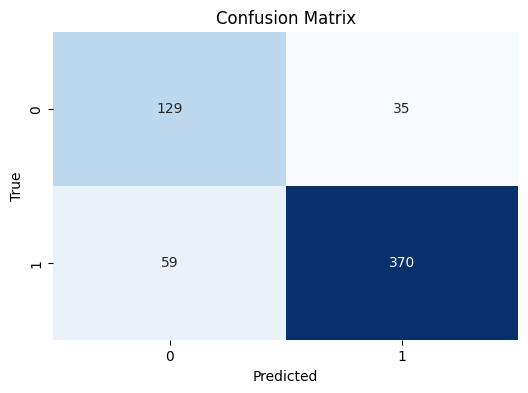

Accuracy: 0.84
Precision: 0.91
Recall: 0.86
F1 Score: 0.89


In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

In [13]:
# Save the updated dataframe to a new CSV file
df.to_csv("your_updated_dataset.csv", index=False)